In [22]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'omkar_proj.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [36]:
from contract.models import Rental as ContractRental,Investor as ContractInvestor
from datetime import datetime,date,timedelta
from dateutil.relativedelta import relativedelta
from django.db.models.functions import ExtractMonth, ExtractYear,ExtractDay
from django_pandas.io import read_frame
import calendar
import pandas as pd
from django.db.models import Count,F,Q,Case,When,Value,OuterRef
from django.db.models import IntegerField, ExpressionWrapper,DateField,DurationField,DateTimeField
from django.utils import timezone
from django.db.models.functions import Cast, ExtractDay, Trunc,Now,Extract
from django_pandas.io import read_frame
from warehouse.models import Company,Gala


In [37]:
import calendar, pandas as pd
from django.shortcuts import render
from datetime import date
from dateutil.relativedelta import relativedelta
from django.db.models.functions import ExtractMonth, ExtractYear
from django_pandas.io import read_frame
from contract.models import Rental as ContractRental
# from .utils import get_plot
import matplotlib.pyplot as plt, base64
from django.core.mail import EmailMessage
from django.http import HttpResponse
from django.core.mail import send_mail

In [60]:
get_owner_warehouse_queryset = Company.objects.get(name="Omkar").get_properties.filter(
    Q(get_gala__gala_investor_contract_detail__owner__is_superuser=True) |
    Q(get_gala__gala_rental_contract_detail__owner__is_superuser=True),
).values("uid", "property_name", "property_type", "property_survey_number",
         "address", "city", "state", "country").distinct().annotate(

    total_number_of_galas=Gala.objects.filter(
                                    warehouse__uid=OuterRef("uid"),
                                    warehouse__company__name="Omkar"
                                              ).values('warehouse__uid'
                                                       ).annotate(total_number_of_galas=Count("id")).values("total_number_of_galas"),

    total_number_of_investors=ContractInvestor.objects.filter(
                        gala__warehouse__uid=OuterRef("uid"), 
                        owner__is_superuser=True,
                        gala__warehouse__company__name__iexact="Omkar"
                                  ).values("gala__warehouse__uid"
                                           ).annotate(total_number_of_investors=Count("id")).values("total_number_of_investors"),

    total_number_of_rentals=ContractRental.objects.filter(
                                    Q(owner__is_superuser=True)|Q(owner__is_superuser=False),
                                    gala__warehouse__uid=OuterRef("uid"),
                                    
                                    gala__is_allotted_to_rental=True,
                                    gala__warehouse__company__name__iexact="Omkar"
                                            ).values("gala__warehouse__uid"
                                                    ).annotate(total_number_of_rentals=Count("id")).values("total_number_of_rentals"),

    total_number_of_remaining_galas=Gala.objects.filter(
                                            warehouse__uid=OuterRef("uid"),
                                            is_allotted=False ,
                                            is_allotted_to_rental=False,
                                            is_allotted_to_farmer = False,
                                            warehouse__company__name__iexact="Omkar"
                                                        ).values('warehouse__uid'
                                                                 ).annotate(total_number_of_remaining_galas=Count("id")).values("total_number_of_remaining_galas"),

)

In [61]:
query_df = read_frame(get_owner_warehouse_queryset)

In [62]:
query_df

,uid,property_name,property_type,property_survey_number,address,city,state,country,total_number_of_galas,total_number_of_investors,total_number_of_rentals,total_number_of_remaining_galas
0,1ce2e3e4-e0fe-4afa-89eb-ce7c9389c00b,Omkar Warehouse 3,Cold Storage,3,..,..,..,..,2,1.0,1,1
1,690385b0-0e94-445a-b448-a18781846984,Omkar Warehouse 1,Peb,1,Atulya IT Park,Indore,Madha Pradesh,India,3,NaN,2,1


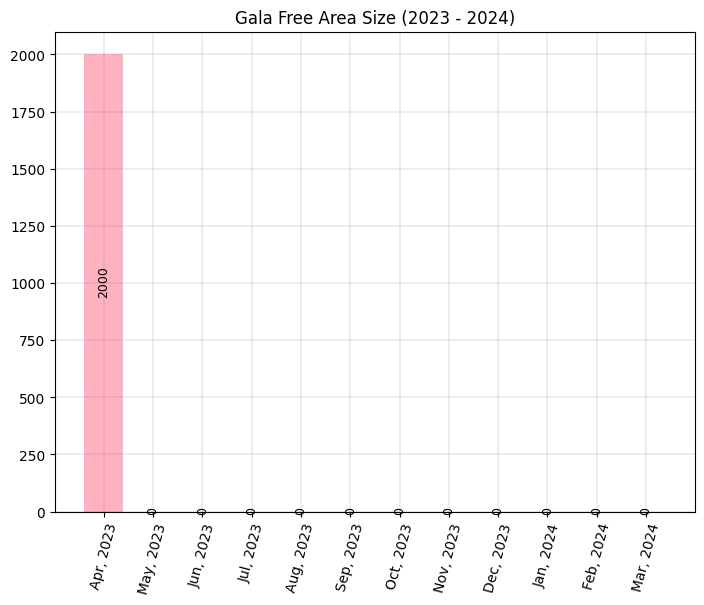

,dates,month_name,month,month_year
0,2023-04-30,Apr,4,2023
1,2023-05-31,May,5,2023
2,2023-06-30,Jun,6,2023
3,2023-07-31,Jul,7,2023
4,2023-08-31,Aug,8,2023
5,2023-09-30,Sep,9,2023
6,2023-10-31,Oct,10,2023
7,2023-11-30,Nov,11,2023
8,2023-12-31,Dec,12,2023
9,2024-01-31,Jan,1,2024


In [4]:
# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i, str(y[i]), str(y[i]), ha = 'center')

get_today_date = date.today() + relativedelta(months=1,day=1)
get_next_year_date = get_today_date + relativedelta(months=11,day=31)
get_contracts = ContractRental.objects.filter(gala__warehouse__company__name="Omkar",
    agreement_valid_end_date__range=[get_today_date.replace(day=1),get_next_year_date]
).annotate(
    month = ExtractMonth('agreement_valid_end_date'),year = ExtractYear('agreement_valid_end_date')
).values("month","gala__gala_area_size","gala__gala_number")
get_contracts_df = read_frame(get_contracts)
dates = pd.date_range(str(get_today_date.replace(day=1)),str(get_next_year_date),freq='M')
df = pd.DataFrame()
df['dates'] = dates
df['month_name'] = df['dates'].dt.strftime('%b')
df['month'] = df['dates'].dt.strftime('%m')
df['month_year'] = df['dates'].dt.strftime('%Y')
df['month'] = df['month'].astype(int)
new_df = pd.merge(df, get_contracts_df, on='month',how="left")
new_df = new_df.groupby(['month', 'month_year','month_name'], as_index=False).agg(free_gala_area_size=('gala__gala_area_size', 'sum'), gala_count=('gala__gala_number', 'count')).sort_values('month_year', ascending=True)
new_df.fillna(0,inplace=True)
new_df['month_year_name'] = new_df['month_name'] + ", " + new_df['month_year']
new_df['message'] = "Count" + " : " + new_df['gala_count'].astype(str)
get_unique_year = new_df['month_year'].unique()
if len(get_unique_year) == 2:
    get_year = get_unique_year[0] + " - " +  get_unique_year[1]
else:
    get_year = get_unique_year[0]
colors = ["#ff638480","#36a2eb80","#ffce5680","#4bc0c080","#9966ff80","#ff9f4080","#98df58","#f9dd51","#ec6464","#24dcd4","#ec64a5","#3090f0"]
years_list = new_df['month_year_name'].tolist()
gala_free_area_list = new_df['free_gala_area_size'].tolist()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c = ["#ff638480","#36a2eb80","#ffce5680","#4bc0c080","#9966ff80","#ff9f4080","#98df58","#f9dd51","#ec6464","#24dcd4","#ec64a5","#3090f0"]
ax.bar(years_list,gala_free_area_list,color = c)
ax.set_title(f'Gala Free Area Size ({get_year})')
# addlabels(years_list, new_df['message'].to_list())
plt.xticks(rotation=75)
ax.bar_label(ax.containers[0],label_type='center', color='black',rotation=90, fontsize=9, padding=1)
# ax.bar_label(bar_container,labels=new_df['message'].tolist(), label_type='center', color='black',rotation=90, fontsize=9, padding=1)
plt.grid(color='grey', linewidth=0.2, axis='both',linestyle='-',)
plt.savefig('media/bar-chart/bar_chart.pdf', dpi=120, format='pdf', bbox_inches='tight')
# plt.savefig('media/bar-chart/barchart.png',bbox_inches='tight',dpi=120,format='png')
plt.show()

# print(get_today_date,get_next_year_date)
df

In [5]:
str(df.iloc[-1][0].date())

'2024-03-31'

In [17]:
new_df['gala_count']

3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
0     0
1     0
2     0
Name: gala_count, dtype: int64

In [21]:
(new_df['gala_count'] != 0).all()

False

In [16]:
new_df['gala_count']

3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
0     0
1     0
2     0
Name: gala_count, dtype: int64

In [6]:
years_lists = new_df['month_year_name'].astype(str)

In [75]:
years_lists.tolist()

['Mar, 2023',
 'Apr, 2023',
 'May, 2023',
 'Jun, 2023',
 'Jul, 2023',
 'Aug, 2023',
 'Sep, 2023',
 'Oct, 2023',
 'Nov, 2023',
 'Dec, 2023',
 'Jan, 2024',
 'Feb, 2024']

In [10]:
show_pie_chart = check_if_all_none(new_df['gala_count'].tolist())
show_pie_chart

False

In [45]:
new_df['gala_count'].tolist()

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [26]:
new_df['message'] = "Free Gala Area Size" + " : " + new_df['free_gala_area_size'].astype(str) + ", " + "Count" + " : " + new_df['gala_count'].astype(str)

In [27]:
new_df['message'].tolist()

['Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 2000.00, Count : 1',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0',
 'Free Gala Area Size : 0, Count : 0']

In [35]:
import plotly.graph_objects as go
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']

fig = go.Figure(data=[go.Pie(labels=years_list,
                             values=new_df['gala_count'].tolist())])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()



In [36]:
import plotly.graph_objects as go

labels = years_list
values = new_df['gala_count'].tolist()

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

In [37]:
import plotly.data as pdata
from barchart3d import barchart3d

df = pdata.gapminder()
df = df[df['year'] == 2007].sort_values(by='pop', ascending=False).head(10)
fig = barchart3d(
    df['country'].to_list(), (df['pop']/1e06).round(1).to_list(),
    'Top 10 most populous countries in 2007 [Gapminder]', 'Population, mln',
    colorscale='Bluered', opacity=0.6, flatshading=True)
fig.show()

ModuleNotFoundError: No module named 'barchart3d'

ERROR: Could not find a version that satisfies the requirement barchart3d (from versions: none)
ERROR: No matching distribution found for barchart3d


In [29]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 8.0 MB/s eta 0:00:00m eta 0:00:010:01:01


In [242]:
get_rental = ContractRental.objects.filter(user_id=10).select_related("gala__warehouse__company","owner").annotate(
    days=F('agreement_valid_end_date')-datetime.today().date(),
    request_count = Count("gala__gala_renew_request"),
    renew_status = F("gala__gala_renew_request__renew_status"),
    leave_request_count = Count("gala__user_gala_leave_request"),
    leave_request_status = F("gala__user_gala_leave_request__status")
).annotate(
    to_be_renewed = Case(
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        leave_request_status = None,
        renew_status = None,    
        then = Value(True)),
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        renew_status__in = ['Reject',None],
        leave_request_status = "Pending",
        then = Value(False)),
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        renew_status = None,
        leave_request_status = "Reject",
        then = Value(True)),
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        renew_status = "Pending",
        leave_request_status = "Reject",
        then = Value(False)),
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        renew_status = "Reject",
        leave_request_status = "Pending",
        then = Value(False)),
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        renew_status = "Reject",
        leave_request_status = "Reject",
        then = Value(True)),
    When(
        Q(days__lte = timedelta(days=90)) & Q(days__gte = timedelta(days=0)) | Q(days__lte = timedelta(days=0)) & Q(days__gte = timedelta(days=-30)),
        renew_status = "Reject",
        leave_request_status = None,
        then = Value(True)),
    default=False
    )
    
)

In [243]:
df = read_frame(get_rental)

In [244]:
df

,id,polymorphic_ctype,uid,created_at,updated_at,contract_ptr,gala,owner,user,agreement_type,...,agreement_valid_doc,ghar_patti_doc,ghar_patti_start_date,ghar_patti_end_date,days,request_count,renew_status,leave_request_count,leave_request_status,to_be_renewed
0,15,contract | rental,8b508695-6ce2-422d-a22c-81b2a1a05ff3,2023-03-20 08:47:06.789129+00:00,2023-03-20 12:01:54.607798+00:00,15,2,admin,mayank,Leave_and_License,...,Leave_and_License/Owner/admin - mayank (8b5086...,Leave_and_License/Owner/admin - mayank (8b5086...,2021-04-20,2022-04-20,1126 days,0,None,0,None,False
1,16,contract | rental,2ae3b813-37e5-4905-a6bb-8676fbfd6939,2023-03-20 09:29:29.531730+00:00,2023-03-20 09:29:48.673649+00:00,16,1,admin,mayank,Leave_and_License,...,Leave_and_License/Owner/admin - mayank (2ae3b8...,Leave_and_License/Owner/admin - mayank (2ae3b8...,2021-03-20,2022-03-20,1095 days,0,None,0,None,False
2,17,contract | rental,a9c8f203-8f65-4845-977b-520ed03aa036,2023-03-20 10:55:34.802663+00:00,2023-03-20 10:58:42.139226+00:00,17,7,admin,mayank,Leave_and_License,...,Leave_and_License/Owner/admin - mayank (a9c8f2...,Leave_and_License/Owner/admin - mayank (a9c8f2...,2018-03-20,2019-03-20,30 days,1,Reject,1,Pending,False


In [217]:
get_rental

<PolymorphicQuerySet [<Rental: Leave_and_License>, <Rental: Leave_and_License>, <Rental: Leave_and_License>]>

In [ ]:
# Case(
#     When(
#         status = "B",
#         bet_on_team = winningTeam,
#         winning_team = winningTeam,
#         then = F('amount') * F("odds") - F("amount")),
#     When(
#         ~Q(bet_on_team = winningTeam),
#         status = "B",
#         winning_team = winningTeam,
#         then = -F('amount')),
#      When(
#         status = "L",
#         bet_on_team = winningTeam,
#         winning_team = winningTeam,
#         then = F('amount') * - F("odds") + F("amount")),
#      When(
#          ~Q(bet_on_team = winningTeam),
#         status = "L",
#         winning_team = winningTeam,
#         then = F('amount')),
#     default=F("loss_profit")
#     )

In [28]:
get_rental = ContractRental.objects.filter(user_id=10).select_related("gala__warehouse__company","owner")

In [16]:
get_rental

<PolymorphicQuerySet [<Rental: Leave_and_License>, <Rental: Leave_and_License>, <Rental: Leave_and_License>]>

In [11]:
str(datetime.today().date())

'2023-03-21'

In [57]:
get_rental_gala = ContractRental.objects.filter(
                user_id=10,locking_period__lte=str(datetime.today().date())
                ).prefetch_related(
                    'gala__user_gala_leave_request'
                    ).values("gala__uid","gala__gala_number").annotate(
                        total_leave_request = Count("gala__user_gala_leave_request"),
                        leave_request_status  = F("gala__user_gala_leave_request__status"),
                        total_gala_renew_request = Count("gala__gala_renew_request"),
                        total_renew_request_status = F("gala__gala_renew_request__renew_status"),
                    ).filter(Q(leave_request_status = None) | Q(leave_request_status = "Reject")).values("gala__uid","gala__gala_number","total_gala_renew_request","total_renew_request_status").distinct().filter(Q(total_renew_request_status = None) | Q(total_renew_request_status = "Reject"))

In [58]:
get_rental_gala

<PolymorphicQuerySet [{'gala__uid': UUID('16b2b643-811b-4828-9a84-d41e957fca3d'), 'gala__gala_number': '1', 'total_gala_renew_request': 0, 'total_renew_request_status': None}, {'gala__uid': UUID('3a686b64-fccc-432f-a331-03221a7f98de'), 'gala__gala_number': 'OM3/1', 'total_gala_renew_request': 1, 'total_renew_request_status': 'Reject'}]>

In [43]:
from django_pandas.io import read_frame

In [31]:
df = read_frame(get_rental_gala)

In [32]:
df

,gala__uid,gala__gala_number,total_gala_renew_request,gala_renew_request_status
0,16b2b643-811b-4828-9a84-d41e957fca3d,1,0,None


In [3]:
get_contracts = ContractRental.objects.filter(gala__warehouse__company__name="Omkar",
    agreement_valid_end_date__month="3", agreement_valid_end_date__year="2023"
)

In [4]:
get_contracts

<PolymorphicQuerySet []>

In [5]:
get_today_date = date.today()

In [6]:
get_next_year_date = get_today_date + relativedelta(years=1)

In [7]:
get_today_date

datetime.date(2023, 3, 18)

In [8]:
get_next_year_date

datetime.date(2024, 3, 18)

In [9]:
get_contracts = ContractRental.objects.filter(gala__warehouse__company__name="Omkar",
    agreement_valid_end_date__range=[get_today_date,get_next_year_date]
).annotate(
    month = ExtractMonth('agreement_valid_end_date'),year = ExtractYear('agreement_valid_end_date')
).values("month","gala__gala_area_size","gala__gala_number")

In [10]:
get_contracts

<PolymorphicQuerySet [{'gala__gala_area_size': Decimal('2000.00'), 'gala__gala_number': 'OM3/1', 'month': 4}, {'gala__gala_area_size': Decimal('2500.00'), 'gala__gala_number': '12', 'month': 4}, {'gala__gala_area_size': Decimal('2000.00'), 'gala__gala_number': '1', 'month': 3}]>

In [11]:
get_contracts_df = read_frame(get_contracts)

In [12]:
get_contracts_df

,gala__gala_area_size,gala__gala_number,month
0,2000.00,OM3/1,4
1,2500.00,12,4
2,2000.00,1,3


In [13]:
import pandas as pd 

dates = pd.date_range(str(get_today_date),str(get_next_year_date),freq='M')

df = pd.DataFrame()
df['dates'] = dates
df['month_name'] = df['dates'].dt.strftime('%b')
df['month'] = df['dates'].dt.strftime('%m')
df['month_year'] = df['dates'].dt.strftime('%Y')
df['month'] = df['month'].astype(int)
df

,dates,month_name,month,month_year
0,2023-03-31,Mar,3,2023
1,2023-04-30,Apr,4,2023
2,2023-05-31,May,5,2023
3,2023-06-30,Jun,6,2023
4,2023-07-31,Jul,7,2023
5,2023-08-31,Aug,8,2023
6,2023-09-30,Sep,9,2023
7,2023-10-31,Oct,10,2023
8,2023-11-30,Nov,11,2023
9,2023-12-31,Dec,12,2023


In [14]:
new_df = pd.merge(df, get_contracts_df, on='month',how="left")

In [15]:
new_df

,dates,month_name,month,month_year,gala__gala_area_size,gala__gala_number
0,2023-03-31,Mar,3,2023,2000.00,1
1,2023-04-30,Apr,4,2023,2000.00,OM3/1
2,2023-04-30,Apr,4,2023,2500.00,12
3,2023-05-31,May,5,2023,NaN,NaN
4,2023-06-30,Jun,6,2023,NaN,NaN
5,2023-07-31,Jul,7,2023,NaN,NaN
6,2023-08-31,Aug,8,2023,NaN,NaN
7,2023-09-30,Sep,9,2023,NaN,NaN
8,2023-10-31,Oct,10,2023,NaN,NaN
9,2023-11-30,Nov,11,2023,NaN,NaN


In [16]:
new_df = new_df.groupby(['month', 'month_year','month_name'], as_index=False).agg(free_gala_area_size=('gala__gala_area_size', 'sum'), gala_count=('gala__gala_number', 'count')).sort_values('month_year', ascending=True)

In [17]:
# new_df.fillna(0,inplace=True)
new_df

,month,month_year,month_name,free_gala_area_size,gala_count
2,3,2023,Mar,2000.00,1
3,4,2023,Apr,4500.00,2
4,5,2023,May,0,0
5,6,2023,Jun,0,0
6,7,2023,Jul,0,0
7,8,2023,Aug,0,0
8,9,2023,Sep,0,0
9,10,2023,Oct,0,0
10,11,2023,Nov,0,0
11,12,2023,Dec,0,0


In [18]:
new_df['month_year_name'] = new_df['month_name'] + ", " + new_df['month_year']

In [19]:
new_df['free_gala_area_size'].tolist()

[Decimal('2000.00'), Decimal('4500.00'), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
new_df['month_year_name'].tolist()

['Mar, 2023',
 'Apr, 2023',
 'May, 2023',
 'Jun, 2023',
 'Jul, 2023',
 'Aug, 2023',
 'Sep, 2023',
 'Oct, 2023',
 'Nov, 2023',
 'Dec, 2023',
 'Jan, 2024',
 'Feb, 2024']

In [21]:
[["Aerospace", 45.0], ["Medical", 26.8],
["Agriculture ", 12.8], ["Automotive", 8.5],
["Consumers", 6.2], ["Subsidies", 0.7]]

[['Aerospace', 45.0],
 ['Medical', 26.8],
 ['Agriculture ', 12.8],
 ['Automotive', 8.5],
 ['Consumers', 6.2],
 ['Subsidies', 0.7]]

In [22]:
len(new_df['month_year'].unique())

2

In [23]:
new_df[['month_year_name','gala_count']].to_dict('index').values()

dict_values([{'month_year_name': 'Mar, 2023', 'gala_count': 1}, {'month_year_name': 'Apr, 2023', 'gala_count': 2}, {'month_year_name': 'May, 2023', 'gala_count': 0}, {'month_year_name': 'Jun, 2023', 'gala_count': 0}, {'month_year_name': 'Jul, 2023', 'gala_count': 0}, {'month_year_name': 'Aug, 2023', 'gala_count': 0}, {'month_year_name': 'Sep, 2023', 'gala_count': 0}, {'month_year_name': 'Oct, 2023', 'gala_count': 0}, {'month_year_name': 'Nov, 2023', 'gala_count': 0}, {'month_year_name': 'Dec, 2023', 'gala_count': 0}, {'month_year_name': 'Jan, 2024', 'gala_count': 0}, {'month_year_name': 'Feb, 2024', 'gala_count': 0}])

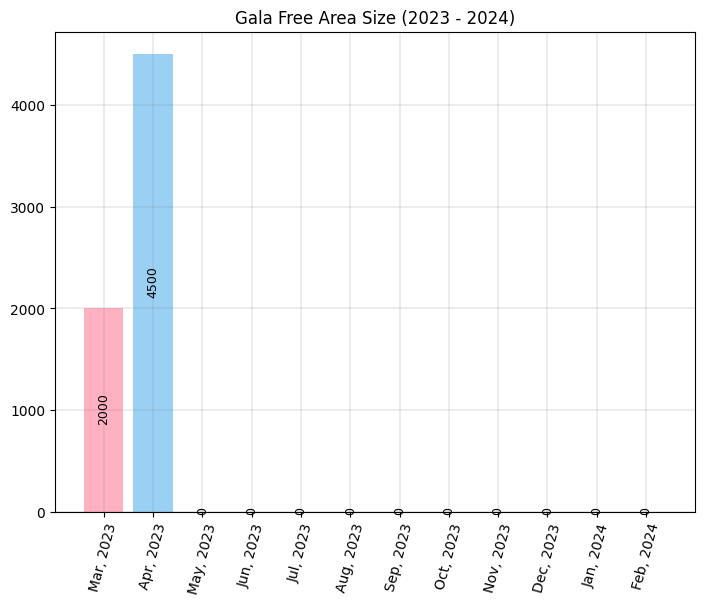

In [24]:
import base64
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from io import BytesIO
get_unique_year = new_df['month_year'].unique()
if len(get_unique_year) == 2:
    get_year = get_unique_year[0] + " - " +  get_unique_year[1]
else:
    get_year = get_unique_year[0]
# with PdfPages(r'charts.pdf') as export_pdf:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c = ["#ff638480","#36a2eb80","#ffce5680","#4bc0c080","#9966ff80","#ff9f4080","#98df58","#f9dd51","#ec6464","#24dcd4","#ec64a5","#3090f0"]
month = new_df['month_year_name'].tolist()
free_gala_area_size = new_df['free_gala_area_size'].tolist()
ax.bar(month,free_gala_area_size,color = c)
ax.set_title(f'Gala Free Area Size ({get_year})')
plt.xticks(rotation=75)
# for rect, label in zip(rects, free_gala_area_size):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="top",rotation=90
#     )
ax.bar_label(ax.containers[0], label_type='center', color='black',rotation=90, fontsize=9, padding=1)
plt.grid(color='grey', linewidth=0.2, axis='both',linestyle='-',)
#     buf = BytesIO()
#     plt.savefig(buf, format='png', dpi=300)
#     image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
#     buf.close()
plt.savefig('bar_chart.pdf', dpi=120, format='pdf', bbox_inches='tight')
plt.show()

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

# recipe = new_df['month_year_name'].tolist()

# data = new_df['gala_count'].tolist()

# wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(arrowprops=dict(arrowstyle="-"),
#           bbox=bbox_props, zorder=0, va="center")

# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1)/2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = f"angle,angleA=0,angleB={ang}"
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                 horizontalalignment=horizontalalignment, **kw)

# ax.set_title("Matplotlib bakery: A donut")

# plt.show()

In [26]:
# import matplotlib.pyplot as plt

# # Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
# sizes = [15, 30, 45, 10]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.show()

In [28]:
from datetime import datetime,timedelta,date

def last_day_of_month(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return next_month - timedelta(days=next_month.day)

In [52]:
last_day_of_month(date(datetime.today().year, datetime.today().month, datetime.today().day)) + timedelta(days=1)

datetime.date(2023, 4, 1)